In [1]:
import torch
import tensorflow as tf
from torch import Tensor
from torch.distributions.transforms import Transform
import numpy as np
import zuko
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from torch import optim
import plot_loss
from tqdm.notebook import trange

2023-01-17 14:10:02.782160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 14:10:05.197300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-17 14:10:05.197637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-17 14:10:05.197662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
from memflow.phasespace import  phasespace
from memflow.hardscatter import hardscatter

In [3]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()

2023-01-17 14:10:13.679773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-01-17 14:10:13.680198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-01-17 14:10:13.680579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-01-17 14:10:13.680927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-01-17 14:10:13.681004: W tensorfl

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Build the flow

In [5]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [6]:
def build_flow(ntransforms=4, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    features = 7
    flow = zuko.flows.NSF(features, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes= 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
flow = build_flow()
flow.to(device)

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 3, 0, 6, 5, 2, 4]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=32, out_features=161, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 6, 5, 4, 2, 3, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_featu

In [14]:
%%timeit

x3 = flow().sample((10000,))

38.9 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 0, 'x2')

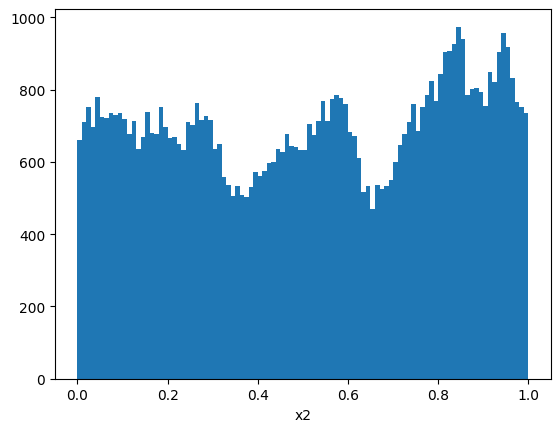

In [16]:
x3 = flow().sample((10000,))
plt.hist(x3.cpu().flatten(), bins=100, range=(0,1))
plt.xlabel("x2")

In [17]:
count_parameters(flow)

30738

# Train the Madgraph probability

In [18]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()

2023-01-16 10:29:06.638025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-01-16 10:29:06.638798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-01-16 10:29:06.639236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-01-16 10:29:06.639642: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-01-16 10:29:06.639742: W tensorfl

In [8]:
from memflow.phasespace import  phasespace
from memflow.hardscatter import hardscatter

In [11]:
E_CM = 13000
N = 10000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)

In [12]:
ps = flow().sample((10000,))
momenta, w , x1, x2 = rambo.get_momenta_from_ps(ps)

In [13]:
pdf_weight =  phasespace.get_pdf_weight(x1, x2, [21,21], pdf)

Text(0, 0.5, 'Top pz')

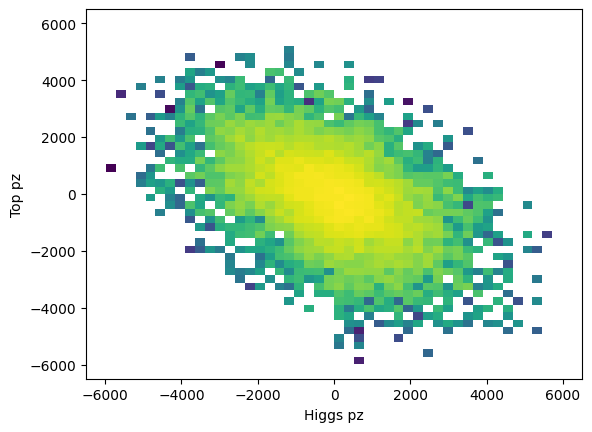

In [15]:
plt.hist2d(momenta[:, 2, -1].numpy(),
           momenta[:, 4, -1].numpy(), 
           range=((-6500.,6500.), (-6500.,6500.)), bins=(50,50),
           weights=w*pdf_weight,
           norm=LogNorm())
plt.xlabel("Higgs pz")
plt.ylabel("Top pz")

In [16]:
with torch.no_grad():
    smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
    shat = x1 * x2 * E_CM**2
    target = smatrix*pdf_weight/(2*shat)
    # The target is the smatrix * pdf * (1/(2s)) * rambo_jacobian
    logp_target = torch.log(target)

Text(0.5, 0, 'Target log(p)')

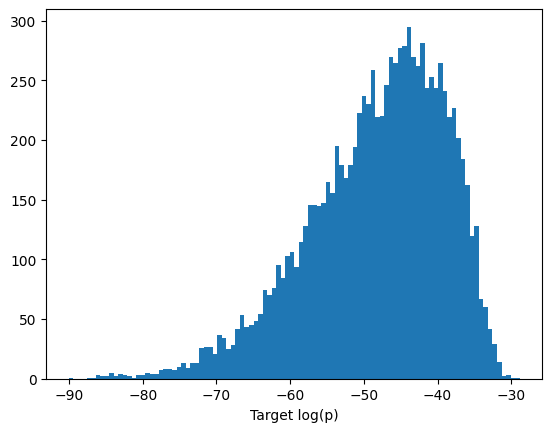

In [17]:
plt.hist(logp_target, bins=100)
plt.xlabel("Target log(p)")

### Forward logprob computation of the flow

In [18]:
# Adding log(detRambo^-1) = - log(detRambo) to the jacobian
logp_g =  flow().log_prob(ps) - w.log()

Text(0.5, 0, 'Flow log prob')

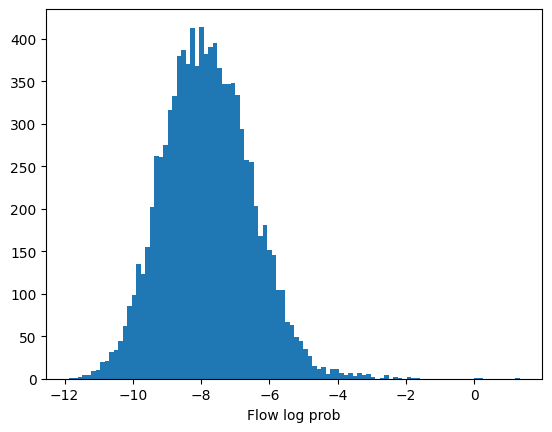

In [19]:
plt.hist(logp_g.detach().numpy(), bins=100)
plt.xlabel("Flow log prob")
#plt.yscale("log")

In [20]:
nanmask = ~logp_target.isnan()

In [27]:
loss = logp_g[nanmask] - logp_target[nanmask]

In [28]:
loss.mean()

tensor(40.4464, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss.mean().backward()

Text(0.5, 0, 'loss')

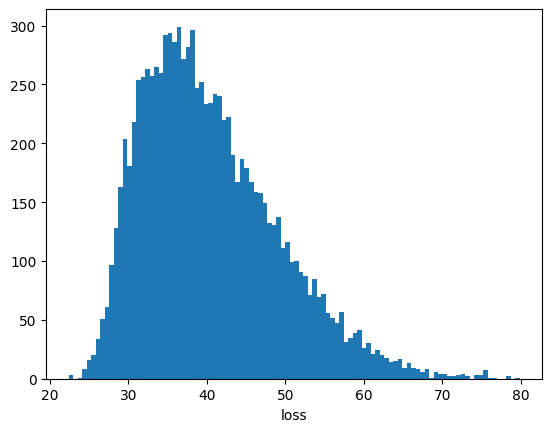

In [30]:
plt.hist(loss.detach().numpy(), bins=100)
plt.xlabel("loss")

# Training loop 

In [5]:
nepochs = 300
nsamples = 10000

In [20]:
flow = build_flow(2, [128]*4, bins=10, autoregressive=True)
optimizer = optim.SGD(flow.parameters(), lr=0.001)
plotter = plot_loss.LossPlotter(["loss","xs","xs_variance"])

E_CM = 13000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)

In [21]:
count_parameters(flow)

153494

In [22]:
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [3, 6, 4, 5, 0, 2, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): MaskedLinear(in_features=128, out_features=203, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [3, 1, 6, 2, 4, 0, 5]
      (hyper): MaskedMLP(
        (0): MaskedLine

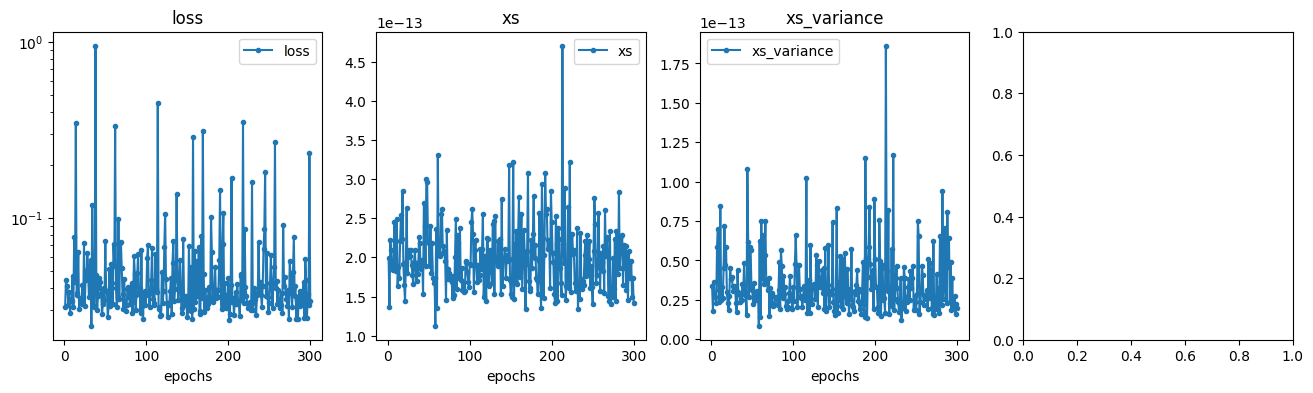

In [23]:
for i in range(nepochs):
    
    with torch.no_grad():
        ps = flow().sample((nsamples,))
        momenta, rambo_jac , x1, x2 = rambo.get_momenta_from_ps(ps)
        pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
    
        # evaluate the smatrix 
        smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
        shat = x1 * x2 * E_CM**2
        # Target function with pdf and 1/2s
        target = smatrix*pdf_weight/(2*shat)
        # nanmask for target=nan
        nanmask = (target>0)
        logp_target = target.log()[nanmask]
        
        
    # Computing the reversed KL divergence loss
    optimizer.zero_grad()
    
    # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
    logp_g =  (flow().log_prob(ps) - rambo_jac.log())[nanmask]

    
    rkl_loss = ((logp_g - logp_target)*logp_g.exp()).mean()
    rkl_loss.backward()
    
    optimizer.step()     
    
    with torch.no_grad():
        # Metrics
        xs = torch.sum(logp_target.exp()/logp_g.exp())/nsamples    
        xs_variance = torch.sqrt((1/(nsamples-1))*(torch.sum((logp_target.exp()/logp_g.exp())**2)/nsamples - (xs)**2))
    
    plotter.on_epoch_end({"loss": rkl_loss.item(), 
                          "xs": xs.item(),
                          "xs_variance": xs_variance.item()})
    
        

(0.0, 0.2)

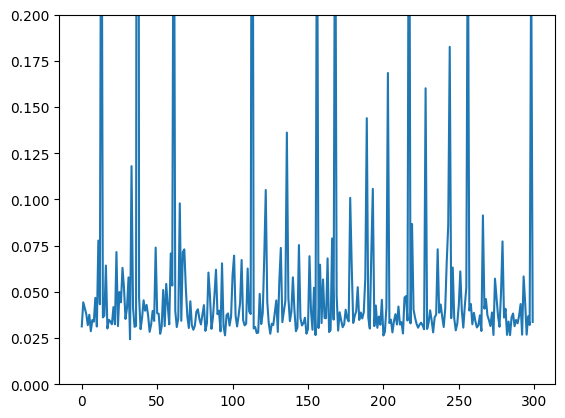

In [26]:
plt.plot(np.arange(300), plotter.metrics["loss"])
plt.ylim(0.,0.2)

In [47]:
ps_test = flow().sample((1000000, ))

(array([[ 89.,  90.,  89., ..., 114., 111.,  85.],
        [104., 109., 114., ..., 107.,  73.,  97.],
        [ 93., 103.,  96., ..., 114.,  95.,  85.],
        ...,
        [ 65., 109.,  79., ..., 101.,  87.,  90.],
        [ 96.,  73.,  88., ...,  89.,  93.,  99.],
        [ 99.,  78.,  91., ..., 103., 107.,  95.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99,

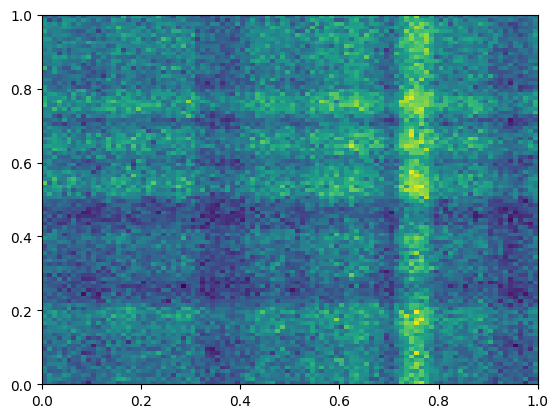

In [49]:
plt.hist2d(ps_test[:,-1].numpy(),
         ps_test[:,-2].numpy(),
         bins=100,
         range=((0,1),(0,1)))

# Buffered training

In [19]:
N_generations = 100
N_buffered_epochs = 5
batch_size = 1024
N = 512000
lr_init = 0.00001

In [20]:
torch.cuda.empty_cache()

In [21]:
flow = build_flow(2, [64]*4, bins=6, autoregressive=True)
flow.to(device)
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

decay = 0.01
fcn = lambda step: 1./(1. + decay*step)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch", "sampling_weight_mean","sampling_weight_std",
                                "loss_gen","xs_gen","xs_var_gen","lr" ])
print(count_parameters(flow))
E_CM = 13000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)


41454


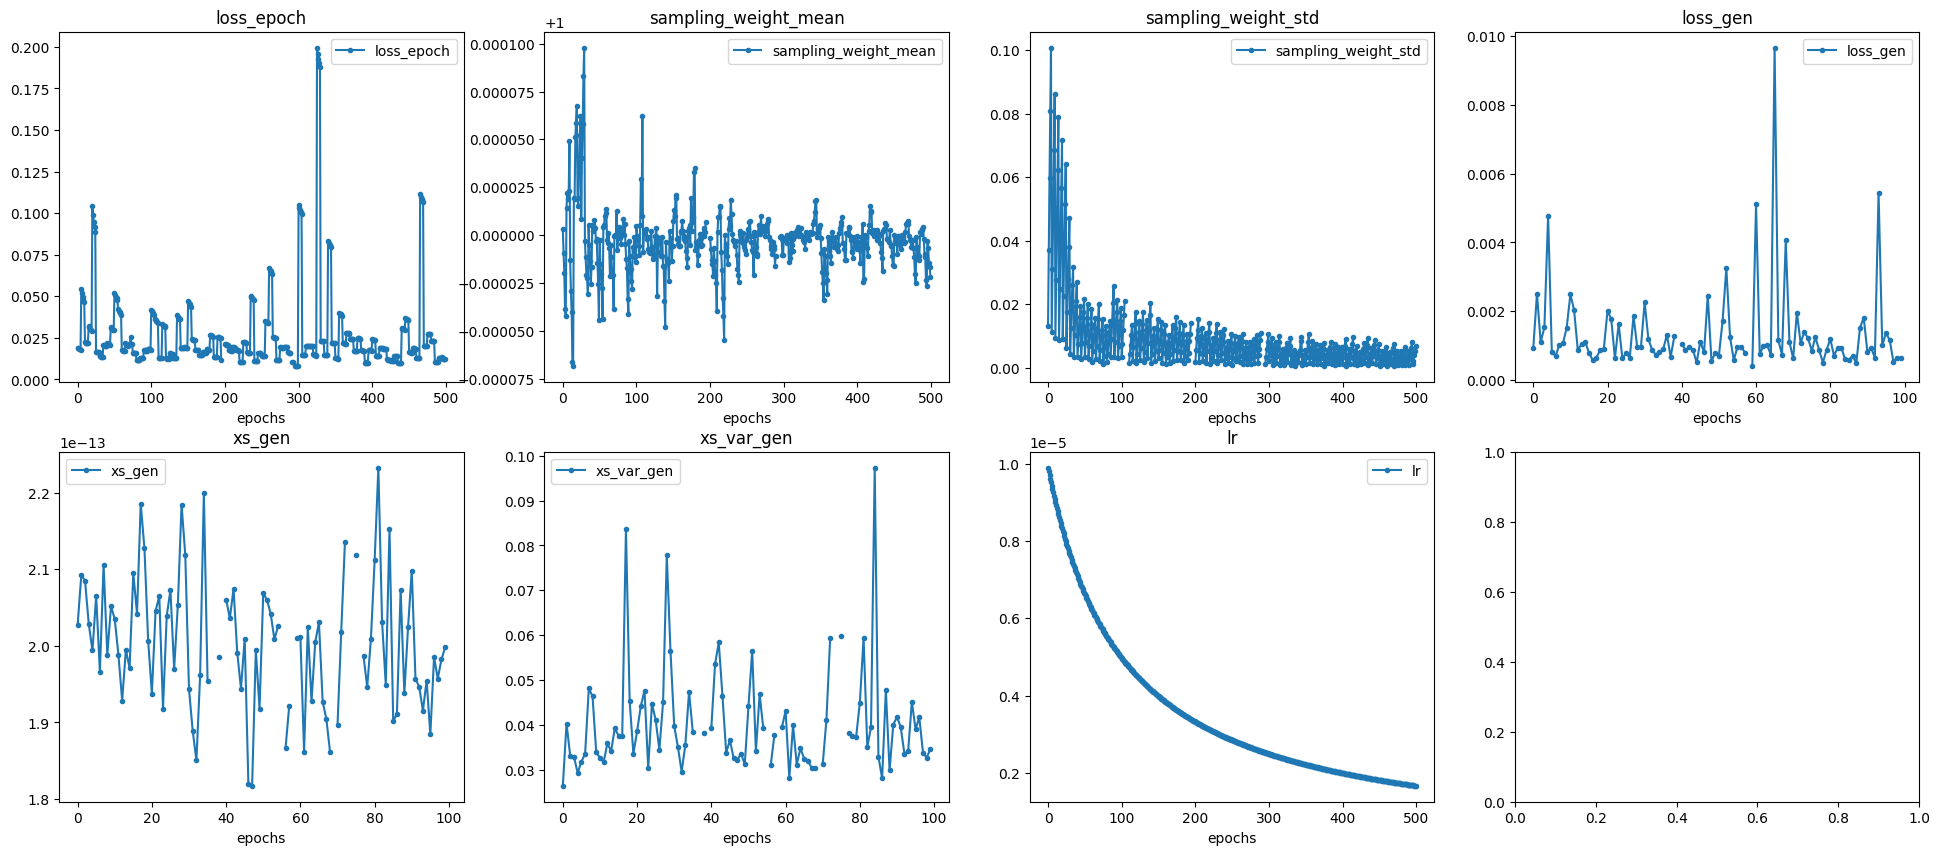

In [22]:
for g in trange(N_generations, desc="Generation"):
    print(f"Generation: {g}")
    # For each epoch we take N samples and then we use them for batched training
    with torch.no_grad():
        print(f"Generating {N} samples")
        ps = flow().sample((N,))
        momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps)
        #avoid borders with ps=1
        rambo_nan = rambo_jac.isnan()
        pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
    
        # evaluate the smatrix 
        print(f"Computing the target prob of {N} samples")
        smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
        shat = x1 * x2 * E_CM**2
        # Target function with pdf and 1/2s
        target = smatrix*pdf_weight/(2*shat)
        # nanmask for target=nan
        nanmask = (target>0)&(~rambo_nan)
        ps = ps[nanmask]
        target = target[nanmask]
        rambo_jac = rambo_jac[nanmask]
        logp_target = target.log()
        # Compute the sampling prob just once
        print(f"Computing the sampling prob of {N} samples")
        logp_sampling = flow().log_prob(ps) - rambo_jac.log()
    
    Ngood = nanmask.sum()
    generation_loss = 0

    for e in trange(N_buffered_epochs,desc="Buffered epochs"):
        
        # Now we can loop on matching batches
        epoch_loss = 0
        epoch_sampling_weight_mean = 0.
        epoch_sampling_weight_std = 0.
        nbuff_epochs = 0
        
        permutation = torch.randperm(Ngood)
        
        for i in trange(0, Ngood, batch_size, desc="Batch"):
            
            indices = permutation[i:i+batch_size]
            
            nbuff_epochs+=1
            ps_i = ps[indices]
            rambo_jac_i = rambo_jac[indices]
            nanmask_i = nanmask[indices]
            logp_target_i = logp_target[indices]
            # Computing the reversed KL divergence loss
            optimizer.zero_grad()

            # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
            logp_g =  flow().log_prob(ps_i) - rambo_jac_i.log()
            assert logp_g.isnan().sum() == 0
            
            # sampling difference weight
            sampling_weight = (logp_g.exp()/logp_sampling[indices].exp()) 
        
            # Weight the loss by logp_g/logp_sampling
            #rkl loss
            loss = (((logp_g - logp_target_i + (torch.ones_like(logp_target_i)*2.232e-13).log() )*logp_g.exp()) * sampling_weight )
            #loss = (sampling_weight*(1+logp_g - logp_target_i)*logp_g)
            
            # Variance loss
            #loss = torch.sum((logp_target_i.exp()**2/(logp_g.exp()*logp_sampling[indices].exp())))/Ngood - \
            #        (torch.sum((logp_target_i.exp())/(logp_sampling[indices].exp()))/Ngood)**2
            
            loss_mean = loss[~loss.isnan()].mean()
            assert loss_mean.isnan() == False
            #print(loss)
            
            #assert loss.isnan().sum() == 0
            #
            scaler.scale(loss_mean).backward()
            scaler.step(optimizer)
            scaler.update()
            # loss_mean.backward()
            # optimizer.step()    
            # if not all([torch.isfinite(p.grad).all() for p in flow.parameters()]):
            #     raise Exception("Invalid gradients")

            epoch_loss += loss_mean.item()
            epoch_sampling_weight_mean += sampling_weight.mean().item()
            epoch_sampling_weight_std += sampling_weight.std().item()
            
        # Decrease learing rate 
        scheduler.step()
        
        with torch.no_grad():
            generation_loss+= epoch_loss/nbuff_epochs
            plotter.on_epoch_end({"loss_epoch": epoch_loss/nbuff_epochs,
                                 "sampling_weight_mean": epoch_sampling_weight_mean/nbuff_epochs,
                                 "sampling_weight_std": epoch_sampling_weight_std/nbuff_epochs,
                                 "lr": scheduler.get_lr()})
    
        
    with torch.no_grad():
        # Compute the XS as validation 
         
        logp_g_val =  flow().log_prob(ps) - rambo_jac.log()
        sampling_weight_val = (logp_g_val.exp()/logp_sampling.exp())
        xs = torch.sum((logp_target - logp_g_val).exp()*sampling_weight_val)/Ngood
        
        xs_variance = torch.sqrt((1/(Ngood-1))*(torch.sum(((logp_target.exp()/logp_g_val.exp())*sampling_weight_val)**2)/Ngood - (xs)**2))
        
        plotter.on_epoch_end({"loss_gen": generation_loss/N_generations,
                             "xs_gen": xs.item(),
                             "xs_var_gen": xs_variance.item()/xs.item()})
        

    
        

In [24]:
torch.save(flow.state_dict(), "flow_2bij_64x5hidden_6bins")

In [25]:
ps_test = flow().sample((1000000, ))

(array([[ 23.,  40.,  36., ...,  32.,  30.,  38.],
        [  7.,   9.,   6., ...,  10.,   2.,   8.],
        [  2.,   2.,   6., ...,   3.,   3.,   6.],
        ...,
        [ 79.,  57.,  51., ..., 108., 104.,  97.],
        [ 84.,  59.,  55., ...,  98.,  99., 110.],
        [ 75.,  72.,  57., ..., 105., 112., 104.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99,

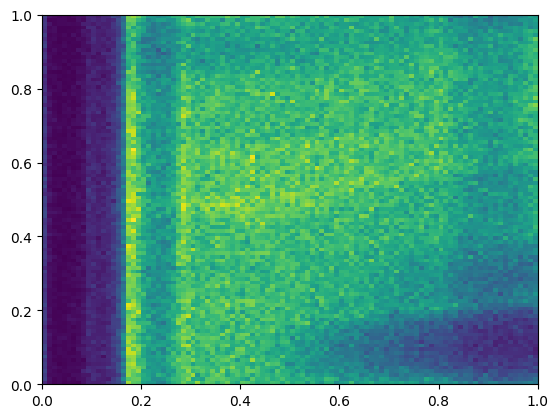

In [34]:
plt.hist2d(ps_test[:,5].cpu().numpy(),
         ps_test[:,6].cpu().numpy(),
         bins=100,
         range=((0,1),(0,1)))

(array([ 3349.,   744.,   406.,   282.,   303.,   367.,   406.,   614.,
          930.,  2024.,  2082.,  1772.,  1871.,  2325.,  3094.,  4595.,
         7778., 15458., 15536., 13539., 11561., 10594.,  9931.,  9945.,
         9850., 10413., 11369., 13105., 14696., 14158., 13286., 12930.,
        12994., 13177., 13395., 13291., 13510., 13333., 13186., 13327.,
        13116., 13410., 13490., 13278., 13174., 13206., 13277., 12918.,
        13235., 12838., 12933., 12784., 12699., 12820., 12377., 12515.,
        12451., 12602., 12416., 12174., 12325., 12231., 12620., 12178.,
        12069., 11892., 11799., 11624., 11641., 11458., 11397., 11374.,
        11374., 10971., 11092., 11141., 11051., 11149., 11210., 11069.,
        11320., 10777., 10275.,  9879.,  9418.,  9241.,  9004.,  8815.,
         8677.,  8502.,  8687.,  8522.,  8545.,  8342.,  8605.,  8816.,
         8897.,  9250.,  9552.,  9972.]),
 array([1.51991844e-06, 1.00014890e-02, 2.00014580e-02, 3.00014280e-02,
        4.00013961e-02

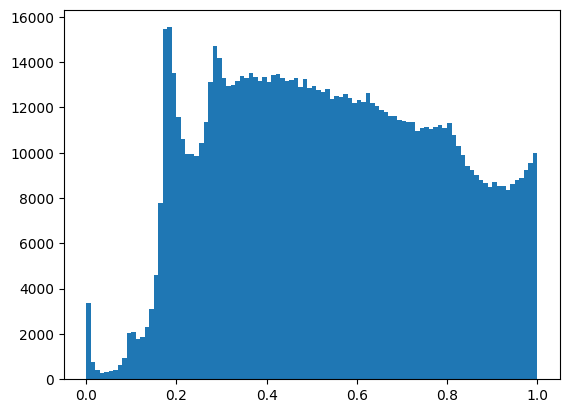

In [37]:
plt.hist(ps_test[:,5].cpu().numpy(), bins=100)

In [44]:
flow()

NormalizingFlow(
  (transform): ComposedTransform(
    (0): AffineTransform()
    (1): AutoregressiveTransform()
    (2): AutoregressiveTransform()
    (3): AutoregressiveTransform()
    (4): AutoregressiveTransform()
    (5): AutoregressiveTransform()
    (6): AutoregressiveTransform()
    (7): AutoregressiveTransform()
    (8): AutoregressiveTransform()
    (9): AutoregressiveTransform()
    (10): AutoregressiveTransform()
    (11): AutoregressiveTransform()
    (12): AutoregressiveTransform()
  )
  (base): BoxUniform(low: torch.Size([7]), high: torch.Size([7]))
)

In [165]:
torch.cuda.empty_cache()

In [38]:
logp_g = flow().log_prob(ps_test)
momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps_test)
pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
shat = x1 * x2 * E_CM**2
# Target function with pdf and 1/2s
target = smatrix*pdf_weight/(2*shat)
logp_target = target.log()

In [54]:
prob_flow = (logp_target- rambo_jac.log()).exp()

In [153]:
N = logp_g.shape[0]

In [158]:
I = torch.sum(target*rambo_jac/logp_g.exp())/N
I

tensor(2.0120e-13, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [161]:
torch.sqrt((torch.sum( (target*rambo_jac/logp_g.exp())**2)/N  - I**2)/(N+1))

tensor(5.5008e-15, device='cuda:0', dtype=torch.float64,
       grad_fn=<SqrtBackward0>)

2.012 +- 0.055 pb

In [140]:
logp_g.shape[0]

1000000

In [ ]:
Uniform prob


In [166]:
ps_unif = torch.rand(1000000,7, device=device)
logp_g = flow().log_prob(ps_unif)
momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps_unif)
pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
shat = x1 * x2 * E_CM**2
# Target function with pdf and 1/2s
target = smatrix*pdf_weight/(2*shat)
logp_target = target.log()

OutOfMemoryError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 10.92 GiB total capacity; 9.86 GiB already allocated; 19.38 MiB free; 10.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [41]:
logp_g 

tensor([0.0330, 0.4138, 0.6078,  ..., 0.3748, 0.6393, 0.7741], device='cuda:0',
       grad_fn=<AddBackward0>)

(array([[   0.,    0.,    0., ...,  468.,  725., 1473.],
        [   0.,    0.,    0., ...,   29.,   24.,   39.],
        [   0.,    0.,    0., ...,   21.,   12.,   22.],
        ...,
        [ 239.,  188.,  122., ...,  428.,  388.,  359.],
        [ 261.,  205.,  143., ...,  445.,  405.,  394.],
        [ 291.,  186.,  156., ...,  477.,  396.,  425.]]),
 array([0.03617454, 0.05545102, 0.0747275 , 0.09400397, 0.11328045,
        0.13255693, 0.15183341, 0.17110989, 0.19038637, 0.20966284,
        0.22893932, 0.2482158 , 0.26749228, 0.28676876, 0.30604523,
        0.32532171, 0.34459819, 0.36387467, 0.38315115, 0.40242763,
        0.4217041 , 0.44098058, 0.46025706, 0.47953354, 0.49881002,
        0.51808649, 0.53736297, 0.55663945, 0.57591593, 0.59519241,
        0.61446889, 0.63374536, 0.65302184, 0.67229832, 0.6915748 ,
        0.71085128, 0.73012776, 0.74940423, 0.76868071, 0.78795719,
        0.80723367, 0.82651015, 0.84578662, 0.8650631 , 0.88433958,
        0.90361606, 0.92289254,

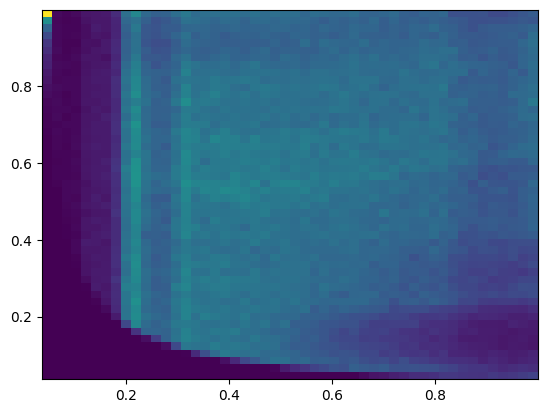

In [106]:
plt.hist2d(x1.cpu().numpy(),
           x2.cpu().numpy(), bins=50,
          )

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.05006630e-18, 3.41560538e-19,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.02019024e-19, 9.23650886e-21,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.78011297e-20, 1.48719312e-22,            nan],
        ...,
        [1.43394198e-18, 3.52565685e-19, 1.74442311e-19, ...,
         9.68001247e-29, 9.94164870e-30,            nan],
        [2.79999598e-19, 4.16839455e-20, 1.61200397e-20, ...,
         5.90560286e-30, 5.44975760e-31,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]),
 array([0.03617454, 0.05545102, 0.0747275 , 0.09400397, 0.11328045,
        0.13255693, 0.15183341, 0.17110989, 0.19038637, 0.20966284,
        0.22893932, 0.2482158 , 0.26749228, 0.28676876, 0.30604523,
        0.32532171, 0.34459819, 0.36387467, 0.38315115, 0.402

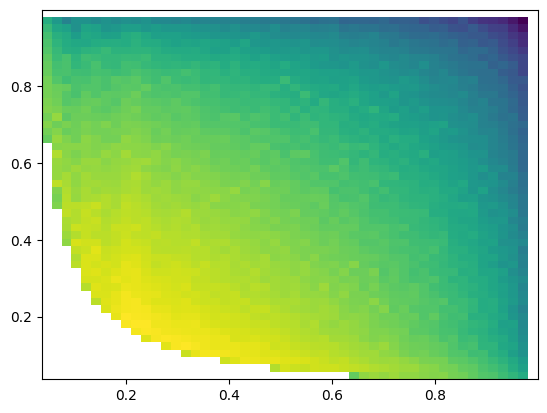

In [112]:
plt.hist2d(x1.cpu().numpy(),
           x2.cpu().numpy(),
           weights=logp_target.exp().cpu().numpy(),
           bins=50,
          norm=LogNorm())

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.69116276e+02, 3.49924577e+02, 1.02149463e+03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.57557945e-01, 8.30713190e-01, 1.45975790e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.87216808e-01, 3.88100572e-01, 6.89478428e-01],
        ...,
        [1.77138832e+02, 9.31985629e+01, 4.44444066e+01, ...,
         4.55043324e+02, 3.85739322e+02, 3.37119972e+02],
        [1.90938107e+02, 1.02348318e+02, 5.29936333e+01, ...,
         4.96920653e+02, 4.26025200e+02, 3.89095549e+02],
        [2.25515159e+02, 9.64526985e+01, 5.96876879e+01, ...,
         5.77163534e+02, 4.45371993e+02, 4.42995206e+02]]),
 array([0.03617454, 0.05545102, 0.0747275 , 0.09400397, 0.11328045,
        0.13255693, 0.15183341, 0.17110989, 0.19038637, 0.20966284,
        0.22893932, 0.2482158 , 0.26749228, 0.28676876, 0.30604523,
        0.32532171, 0.34459819, 0.36387467, 0.38315115, 0.402

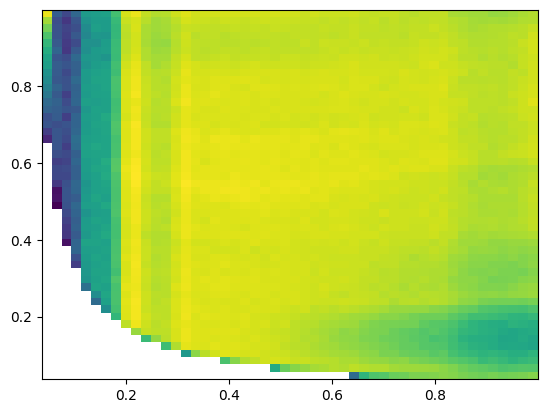

In [110]:
plt.hist2d(x1.cpu().numpy(),
           x2.cpu().numpy(),
           weights=logp_g.exp().detach().cpu().numpy(),
           bins=50,
          norm=LogNorm())

(array([[      0.        ,       0.        ,       0.        , ...,
           36782.04659125,   43423.40482716,   46243.54858638],
        [      0.        ,       0.        ,       0.        , ...,
           13286.70218783,   11064.92659668,   19082.8071032 ],
        [      0.        ,       0.        ,       0.        , ...,
           17953.80136143,   12435.0847337 ,   19373.34654829],
        ...,
        [ 182575.75749631,  207470.47643361,  179492.80178752, ...,
         7565998.02309491, 7021203.41417152, 6646303.19511696],
        [ 201279.52788963,  242151.45682941,  220154.53077358, ...,
         8078095.40802353, 7503367.86103955, 7439789.44784292],
        [ 232301.33297676,  213206.60511708,  239915.08076541, ...,
         8844026.45250896, 7469940.84836037, 8214469.5778267 ]]),
 array([0.03617454, 0.05545102, 0.0747275 , 0.09400397, 0.11328045,
        0.13255693, 0.15183341, 0.17110989, 0.19038637, 0.20966284,
        0.22893932, 0.2482158 , 0.26749228, 0.28676876, 0

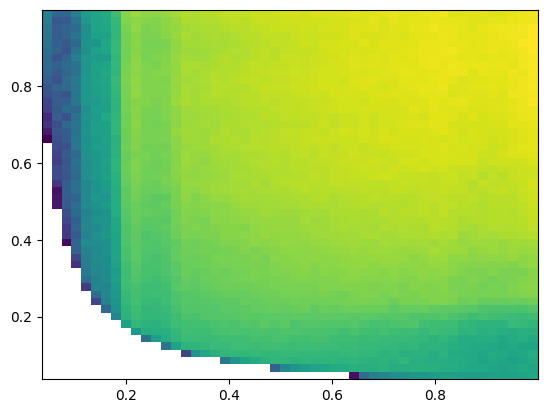

In [97]:
plt.hist2d(x1.cpu().numpy(),
           x2.cpu().numpy(),
           weights=rambo_jac.cpu().numpy(),
           bins=50,
          norm=LogNorm())

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 2., ..., 0., 0., 0.]]),
 array([0.03645517, 0.04609062, 0.05572606, 0.0653615 , 0.07499694,
        0.08463238, 0.09426783, 0.10390327, 0.11353871, 0.12317415,
        0.1328096 , 0.14244504, 0.15208048, 0.16171592, 0.17135137,
        0.18098681, 0.19062225, 0.20025769, 0.20989313, 0.21952858,
        0.22916402, 0.23879946, 0.2484349 , 0.25807035, 0.26770579,
        0.27734123, 0.28697667, 0.29661212, 0.30624756, 0.315883  ,
        0.32551844, 0.33515388, 0.34478933, 0.35442477, 0.36406021,
        0.37369565, 0.3833311 , 0.39296654, 0.40260198, 0.41223742,
        0.42187287, 0.43150831, 0.44114375, 0.45077919, 0.46041463,
        0.47005008, 0.47968552, 0.48932096, 0.4989564 , 0.50859185,
        0.51822729, 0.52786273, 0.53749817, 0.54713362, 0.55676906,
   

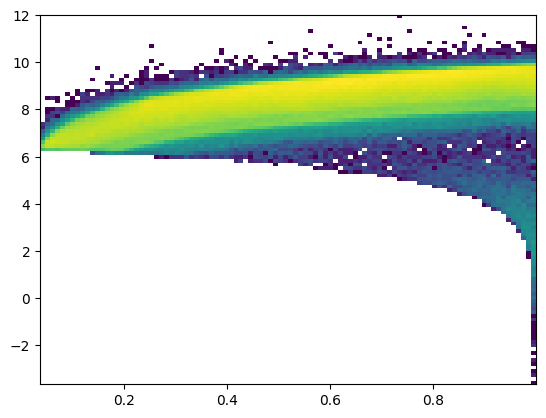

In [104]:
plt.hist2d(x2.cpu().numpy(),
          rambo_jac.log().cpu().numpy(),
           bins=100,
          norm=LogNorm())

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4.1760006 , -4.12021492, -4.06442924, -4.00864356, -3.95285788,
        -3.8970722 , -3.84128652, -3.78550084, -3.72971516, -3.67392948,
        -3.6181438 , -3.56235812, -3.50657244, -3.45078676, -3.39500108,
        -3.3392154 , -3.28342972, -3.22764404, -3.17185836, -3.11607268,
        -3.060287  , -3.00450132, -2.94871564, -2.89292996, -2.83714428,
        -2.7813586 , -2.72557292, -2.66978724, -2.61400156, -2.55821588,
        -2.5024302 , -2.44664452, -2.39085884, -2.33507316, -2.27928748,
        -2.2235018 , -2.16771612, -2.11193044, -2.05614476, -2.00035908,
        -1.9445734 , -1.88878772, -1.83300204, -1.77721636, -1.72143068,
        -1.665645  , -1.60985932, -1.55407364, -1.49828796, -1.44250228,
        -1.3867166 , 

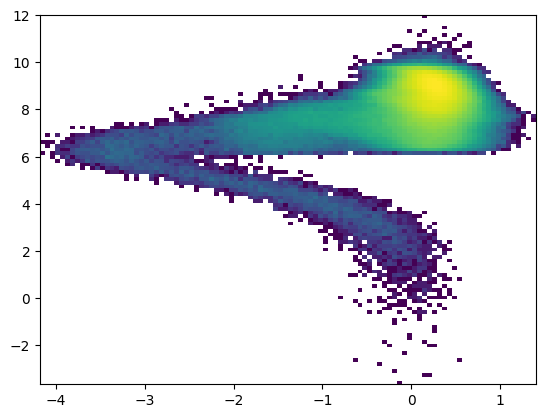

In [100]:
plt.hist2d(logp_g.cpu().detach().numpy(),
           rambo_jac.log().cpu().numpy(),
           bins=100,
          norm=LogNorm())

(array([  5833.,  71435., 115628., 131642., 131314., 125006., 119150.,
        111321.,  95314.,  88780.]),
 array([0.04054546, 0.13649076, 0.23243606, 0.32838136, 0.42432666,
        0.52027196, 0.61621726, 0.71216255, 0.80810785, 0.90405315,
        0.99999845]),
 <BarContainer object of 10 artists>)

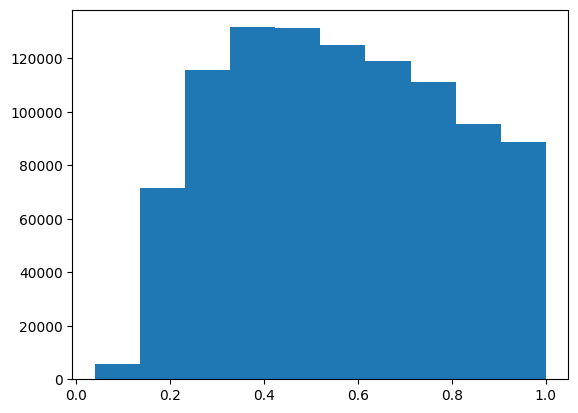

In [102]:
plt.hist(x1[rambo_jac.log()>6].cpu().numpy(), )

(array([3.106e+03, 7.700e+02, 4.030e+02, 1.440e+02, 6.500e+01, 4.600e+01,
        2.500e+01, 9.000e+00, 6.000e+00, 3.000e+00]),
 array([0.03617454, 0.04399164, 0.05180873, 0.05962583, 0.06744293,
        0.07526003, 0.08307713, 0.09089422, 0.09871132, 0.10652842,
        0.11434551]),
 <BarContainer object of 10 artists>)

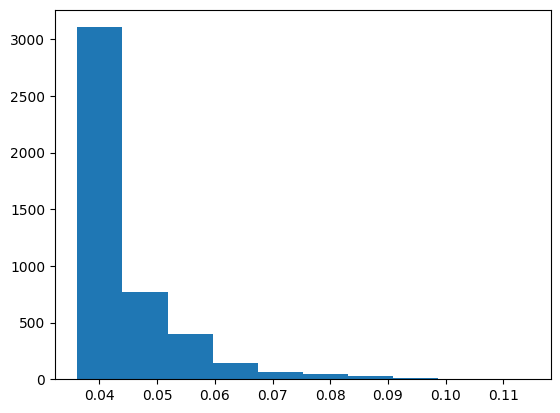

In [101]:
plt.hist(x1[rambo_jac.log()<6].cpu().numpy(), )

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.88621881e-05, 3.64090808e-05, 1.07294347e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.57166337e-07, 8.40605707e-08, 8.08067046e-08],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.46991184e-08, 2.40752829e-09, 9.39571532e-08],
        ...,
        [6.90075212e-07, 2.02494698e-07, 1.93402490e-07, ...,
         7.80490072e-09, 7.08943400e-09, 3.80914862e-09],
        [1.42633510e-06, 3.51977787e-07, 1.32009698e-07, ...,
         5.53438928e-09, 3.11680101e-09, 4.35285059e-09],
        [9.45890491e-07, 5.06539000e-07, 1.20589459e-07, ...,
         1.76124455e-08, 9.95912624e-09, 1.98538756e-08]]),
 array([0.03617454, 0.05545102, 0.0747275 , 0.09400397, 0.11328045,
        0.13255693, 0.15183341, 0.17110989, 0.19038637, 0.20966284,
        0.22893932, 0.2482158 , 0.26749228, 0.28676876, 0.30604523,
        0.32532171, 0.34459819, 0.36387467, 0.38315115, 0.402

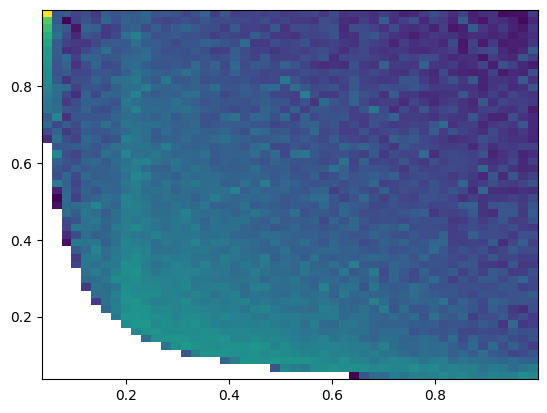

In [95]:
plt.hist2d(x1.cpu().numpy(),
           x2.cpu().numpy(),
           weights=prob_flow.cpu().numpy(),
           bins=50, norm=LogNorm()
        )

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 6.0000e+00, 1.7000e+01, 4.9000e+01, 1.1700e+02,
        3.5800e+02, 1.1220e+03, 3.3220e+03, 7.7060e+03, 1.5500e+04,
        2.6990e+04, 4.1640e+04, 5.4046e+04, 6.3868e+04, 6.8056e+04,
        7.0109e+04, 7.0734e+04, 7.0306e+04, 6.7551e+04, 6.3490e+04,
        5.9310e+04, 5.3317e+04, 4.7012e+04, 4.0395e+04, 3.3431e+04,
        2.7795e+04, 2.3654e+04, 2.0320e+04, 1.7320e+04, 1.4903e+04,
        1.2359e+04, 9.8950e+03, 6.7780e+03, 3.6300e+03, 1.6150e+03,
        6.3200e+02, 2.8200e+02, 1.4600e+02, 1.1100e+02, 1.0400e+02,
        1.0500e+02, 1.0500e+02, 1.0700e+02, 1.0400e+02, 9.8000e+01,
        9.8000e+01, 8.7000e+01, 8.6000e+01, 1.0700e+02, 9.8000e+01,
        7.8000e+01, 9.1000e+01, 8.5000e+01, 6.5000e+01, 5.9000e+01,
        7.5000e+01, 5.3000e+01, 6.3000e+01, 5.1000e+01, 5.1000e+01,
        3.7000e+01, 3.5000e+01, 3.6000e+01, 1.9000e+01, 2.7000e+01,
        2.9000e+01, 2.0000e+01, 7.0000e+00, 1.00

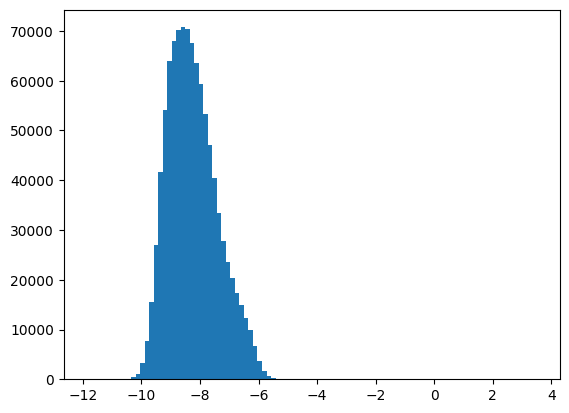

In [50]:
plt.hist((logp_g-rambo_jac.log()).cpu().detach().numpy(), bins=100)

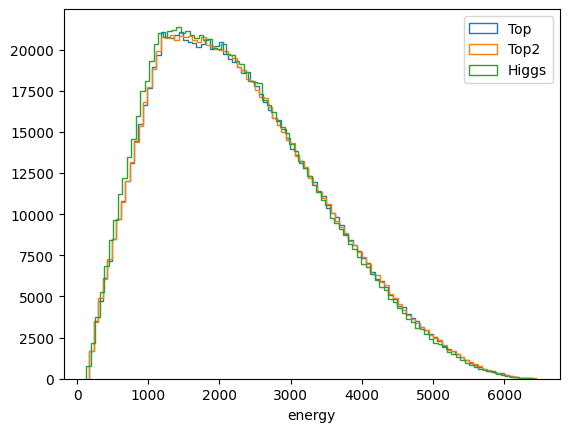

In [52]:
plt.hist(momenta[:,4,0].cpu().numpy(), bins=100, histtype="step", label="Top")
plt.hist(momenta[:,3,0].cpu().numpy(), bins=100, histtype="step", label="Top2")
#plt.hist(momenta[:,0,1].numpy(), bins=100, histtype="step", label="Gluon")
#plt.hist(momenta[:,1,1].numpy(), bins=100, histtype="step", label="Gluon2")
plt.hist(momenta[:,2,0].cpu().numpy(), bins=100, histtype="step", label="Higgs")
plt.xlabel("energy")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


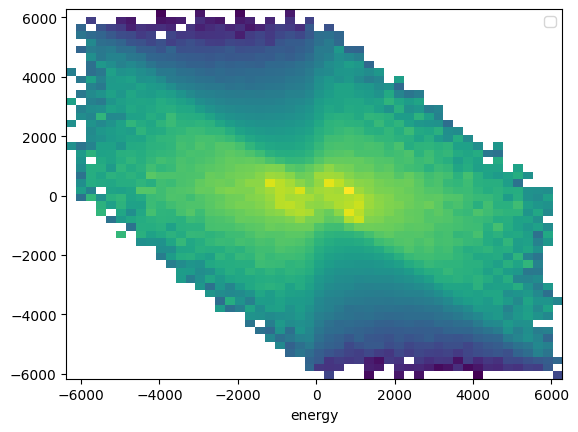

In [60]:
plt.hist2d(momenta[:,4,-1].cpu().numpy(), 
         momenta[:,2,-1].cpu().numpy(),
         weights=prob_flow.cpu().numpy(),bins=50,
          norm=LogNorm())

plt.xlabel("energy")
plt.legend()

In [ ]:
torch.on

In [122]:
np.log(2e-13)

-29.240459028362647

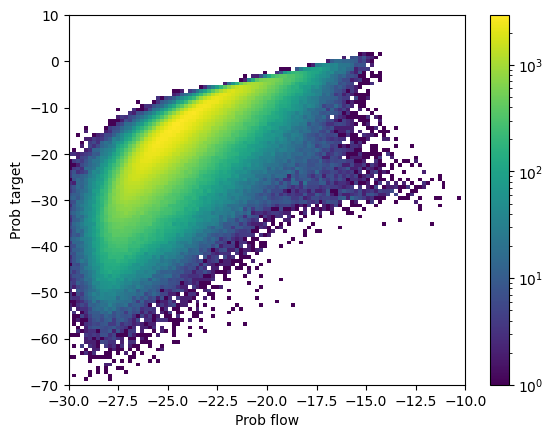

In [127]:
plt.hist2d(prob_flow.log().detach().cpu().numpy(), 
           (logp_target + 29.240 ).cpu().numpy(),
          bins=(100,100),
          norm=LogNorm(), 
          range=((-30,-10),(-70,10)))
plt.xlabel("Prob flow")
plt.ylabel("Prob target")
plt.colorbar()

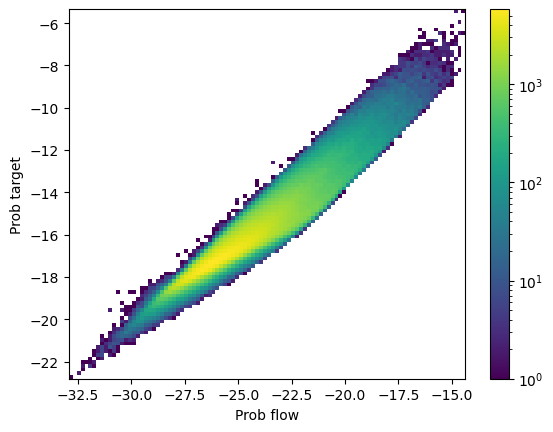

In [136]:
plt.hist2d(prob_flow[x1>0.2].log().detach().cpu().numpy(), 
           (smatrix[x1>0.2].log()).cpu().numpy(),
          bins=(100,100),
          norm=LogNorm())
plt.xlabel("Prob flow")
plt.ylabel("Prob target")
plt.colorbar()

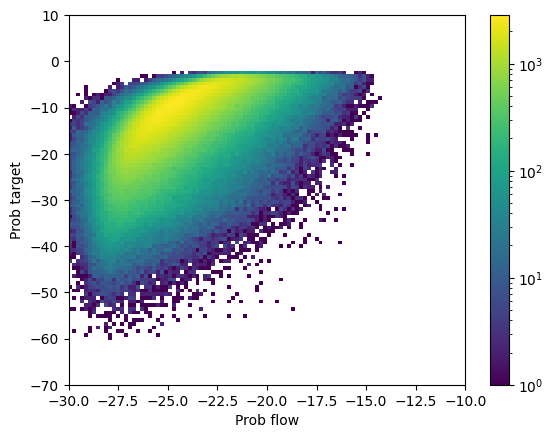

In [137]:
plt.hist2d(prob_flow[x1>0.2].log().detach().cpu().numpy(), 
           (pdf_weight[x1>0.2].log()).cpu().numpy(),
          bins=(100,100),
          norm=LogNorm(),
          range=((-30,-10),(-70,10)))
plt.xlabel("Prob flow")
plt.ylabel("Prob target")
plt.colorbar()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([   0.,   65.,  130.,  195.,  260.,  325.,  390.,  455.,  520.,
         585.,  650.,  715.,  780.,  845.,  910.,  975., 1040., 1105.,
        1170., 1235., 1300., 1365., 1430., 1495., 1560., 1625., 1690.,
        1755., 1820., 1885., 1950., 2015., 2080., 2145., 2210., 2275.,
        2340., 2405., 2470., 2535., 2600., 2665., 2730., 2795., 2860.,
        2925., 2990., 3055., 3120., 3185., 3250., 3315., 3380., 3445.,
        3510., 3575., 3640., 3705., 3770., 3835., 3900., 3965., 4030.,
        4095., 4160., 4225., 4290., 4355., 4420., 4485., 4550., 4615.,
        4680., 4745., 4810., 4875., 4940., 5005., 5070., 5135., 5200.,
        5265., 5330., 5395., 5460., 5525., 5590., 5655., 5720., 5785.,
        5850., 5915., 5980., 6045., 6110.

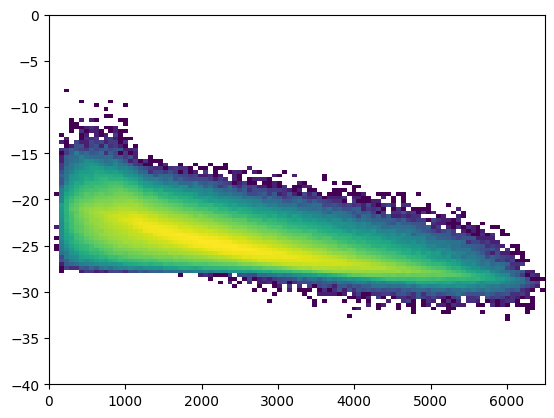

In [80]:
plt.hist2d(momenta[:,2,0].cpu().numpy(), prob_flow.log().cpu().numpy(),
          bins=(100,100),
           range=((0.,6500.),(-40.,0.)), norm=LogNorm())

# Study of the target

In [10]:
ps_test = torch.rand(1500000, 7, device=device)
momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps_test)
#momenta = momenta.to("cpu")
pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
shat = x1 * x2 * E_CM**2
# Target function with pdf and 1/2s
target = smatrix
tot_target = (smatrix*pdf_weight/(2*shat)).log()
logp_target = target.log()

tot_target[torch.isnan(tot_target)] = 0.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Gluons and |M|^2 target

Text(0, 0.5, '|M|^2')

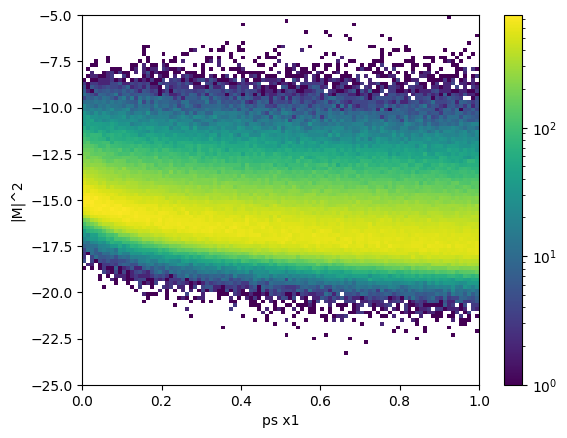

In [118]:
plt.hist2d(ps_test[:,-1].numpy(), 
           logp_target,
          bins=100, range=((0, 1), (-25,-5)), 
          norm=LogNorm())
plt.xlabel("ps x1")
plt.colorbar()
plt.ylabel("|M|^2")

Text(0, 0.5, '|M|^2')

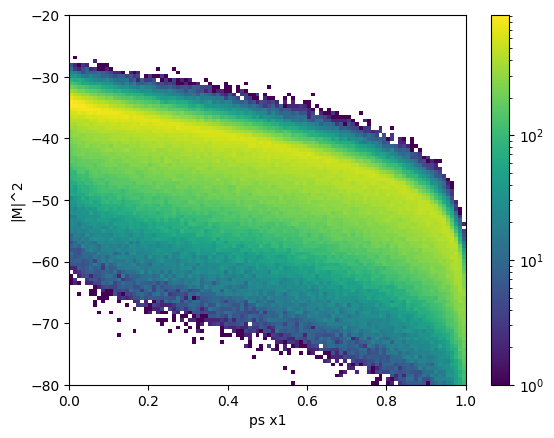

In [125]:
plt.hist2d(ps_test[:,-1].numpy(), 
           tot_target,
          bins=100, range=((0, 1), (-80,-20)), 
          norm=LogNorm())
plt.xlabel("ps x1")
plt.colorbar()
plt.ylabel("|M|^2")

Text(0.5, 0, 'ps x2')

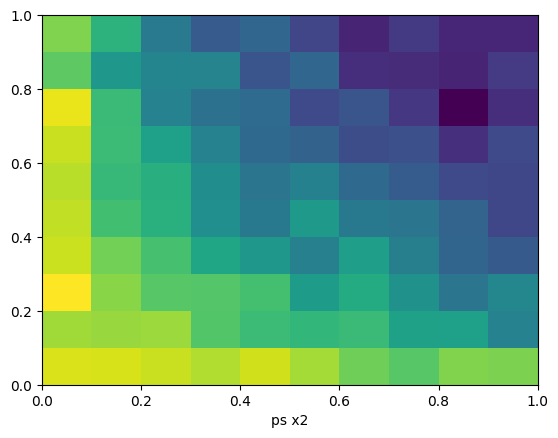

In [119]:
plt.hist2d(ps_test[:,-1].numpy(), 
           ps_test[:,-2].numpy(),
           weights=logp_target,
          bins=10, range=((0, 1), (0,1)))
plt.xlabel("ps x1")
plt.xlabel("ps x2")

## PS points vs target

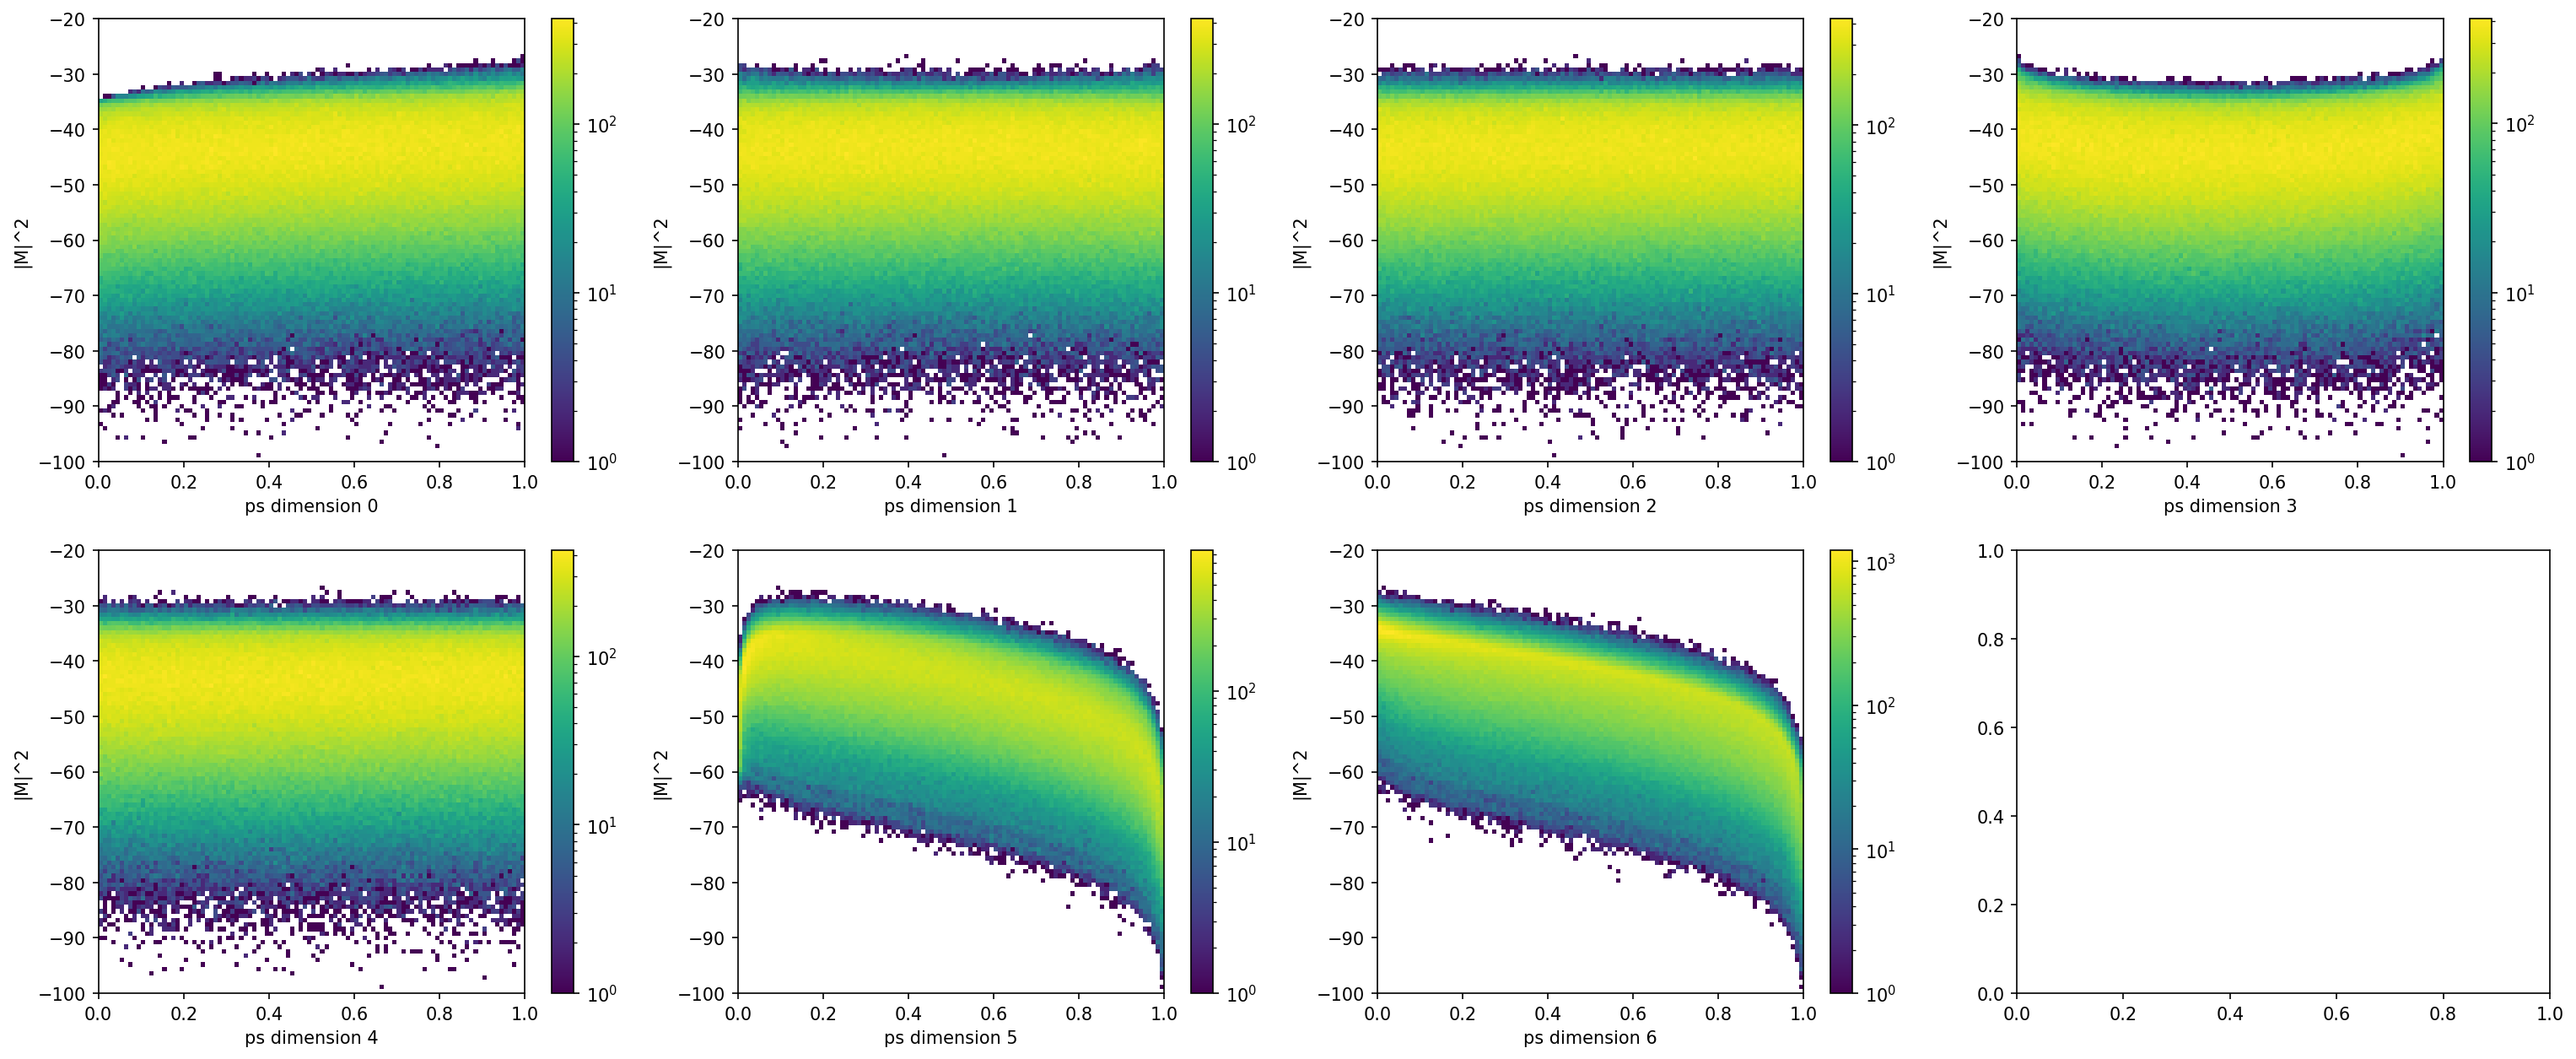

In [152]:
fig , axs = plt.subplots(2, 4, figsize=(25, 10), dpi=150)

for i in range(7):
    ax = axs[i //4][i %4]
    a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
           tot_target,
           bins=100, range=((0, 1), (-100,-20)), 
           norm=LogNorm())
    ax.set_xlabel(f"ps dimension {i}")
    plt.colorbar(I, ax=ax)
    ax.set_ylabel("|M|^2")

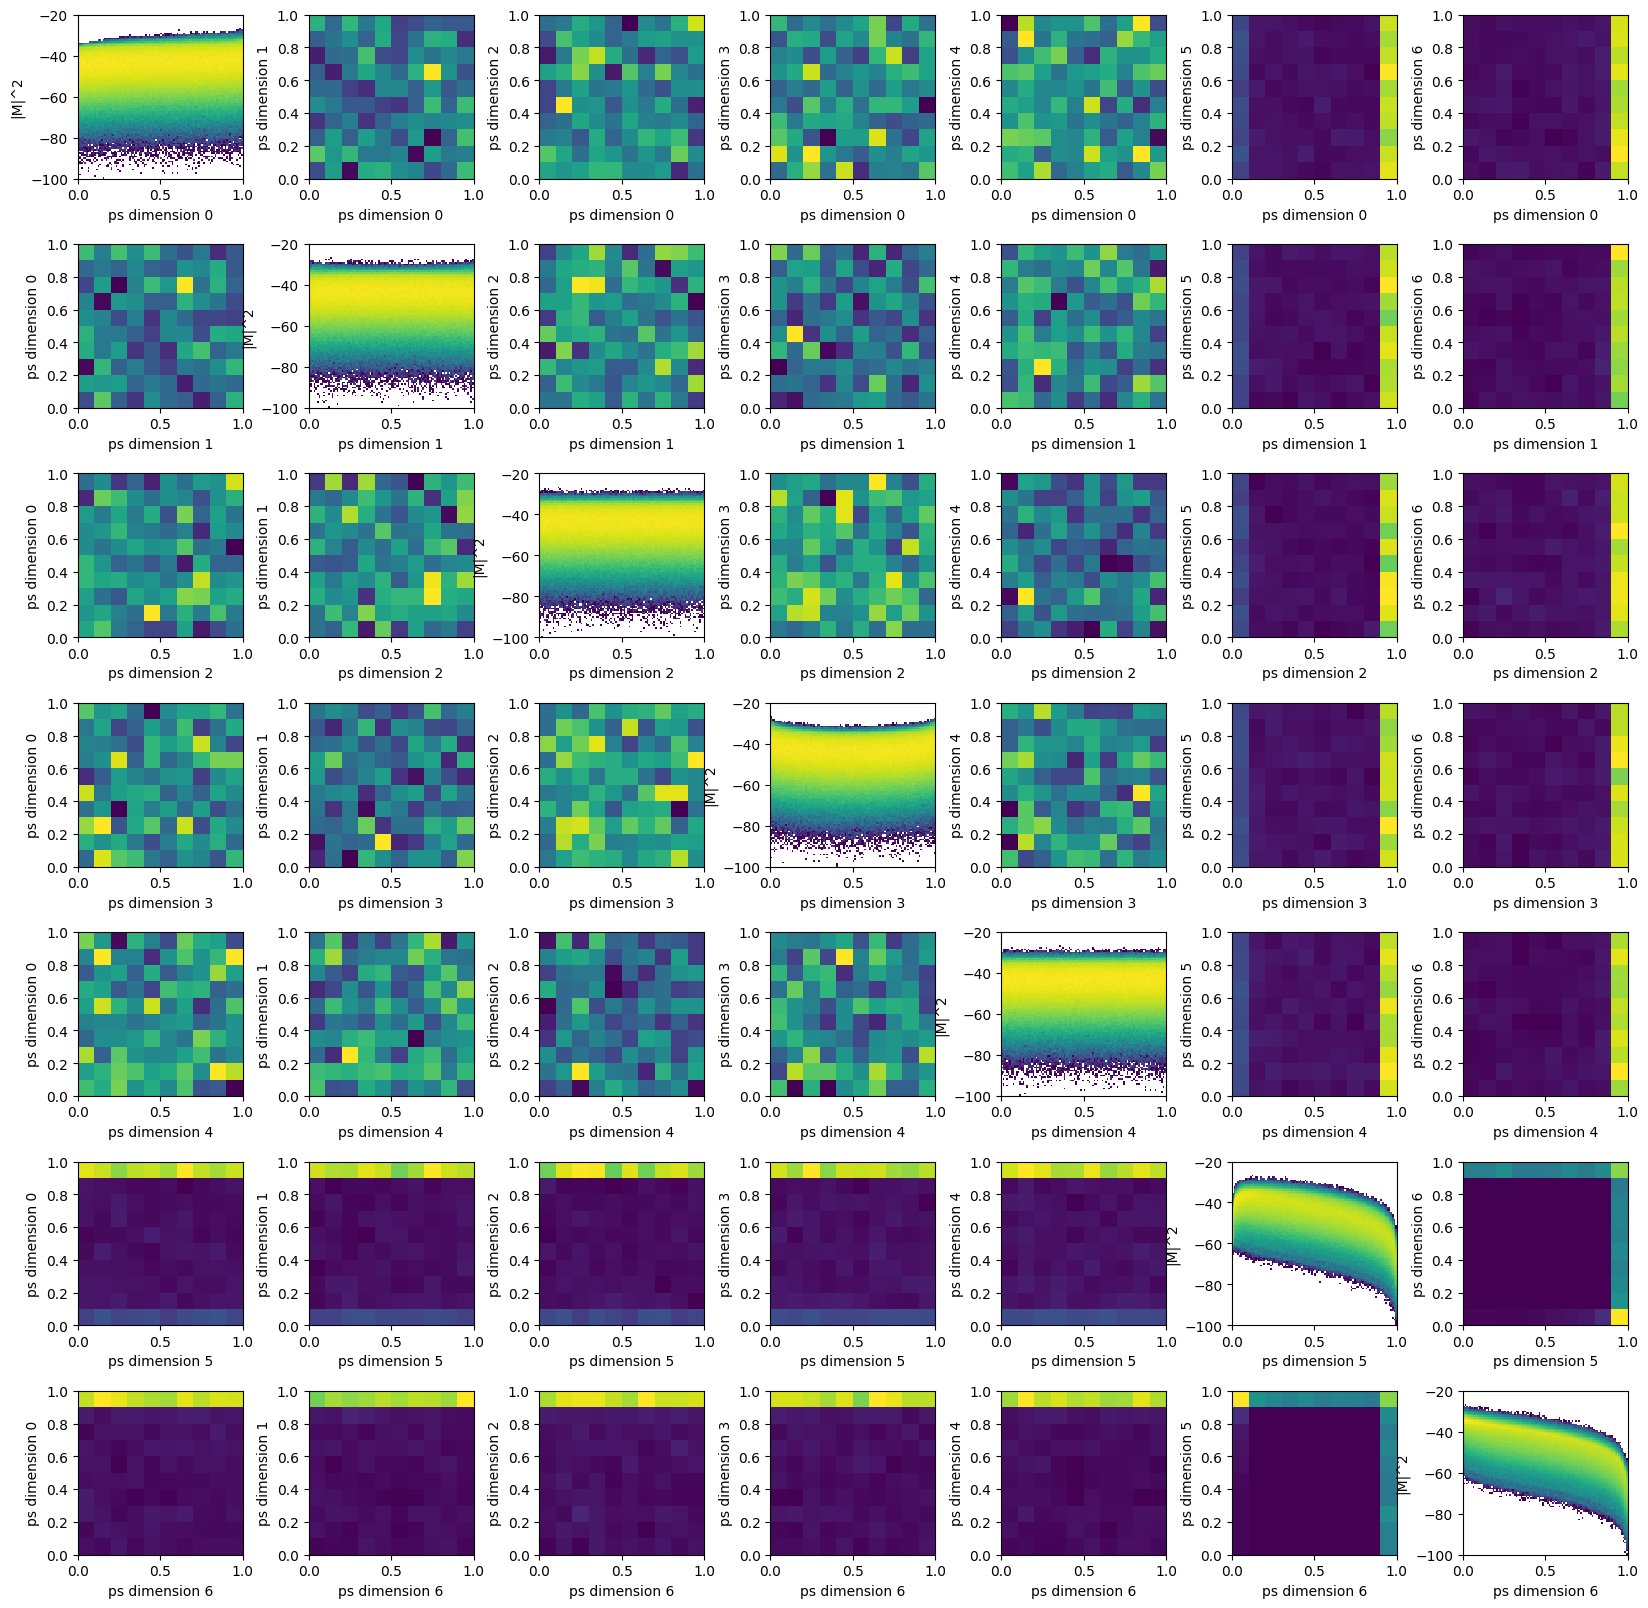

In [229]:
fig , axs = plt.subplots(7, 7, figsize=(20, 20), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(7):
    for j in range(7):
        ax = axs[i][j]
        # if j>i: 
        #     fig.delaxes(ax)
        #     continue
        
        if i == j:
            a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
                   tot_target,
                   bins=100, range=((0, 1), (-100,-20)), 
                   norm=LogNorm())
            ax.set_xlabel(f"ps dimension {i}")
            #plt.colorbar(I, ax=ax)
            ax.set_ylabel("|M|^2")
        else:
            H, bx,by = np.histogram2d(
                ps_test[:,i].numpy(), 
                ps_test[:,j].numpy(),
                weights=np.exp(tot_target),
            bins=10, range=((0, 1), (0,1)))
            X, Y = np.meshgrid(bx, by)
            ax.pcolormesh(X, Y, H/1e6)
            ax.set_xlabel(f"ps dimension {i}")
            ax.set_ylabel(f"ps dimension {j}")
            #plt.colorbar(I, ax=ax, label="sum |M|^2")

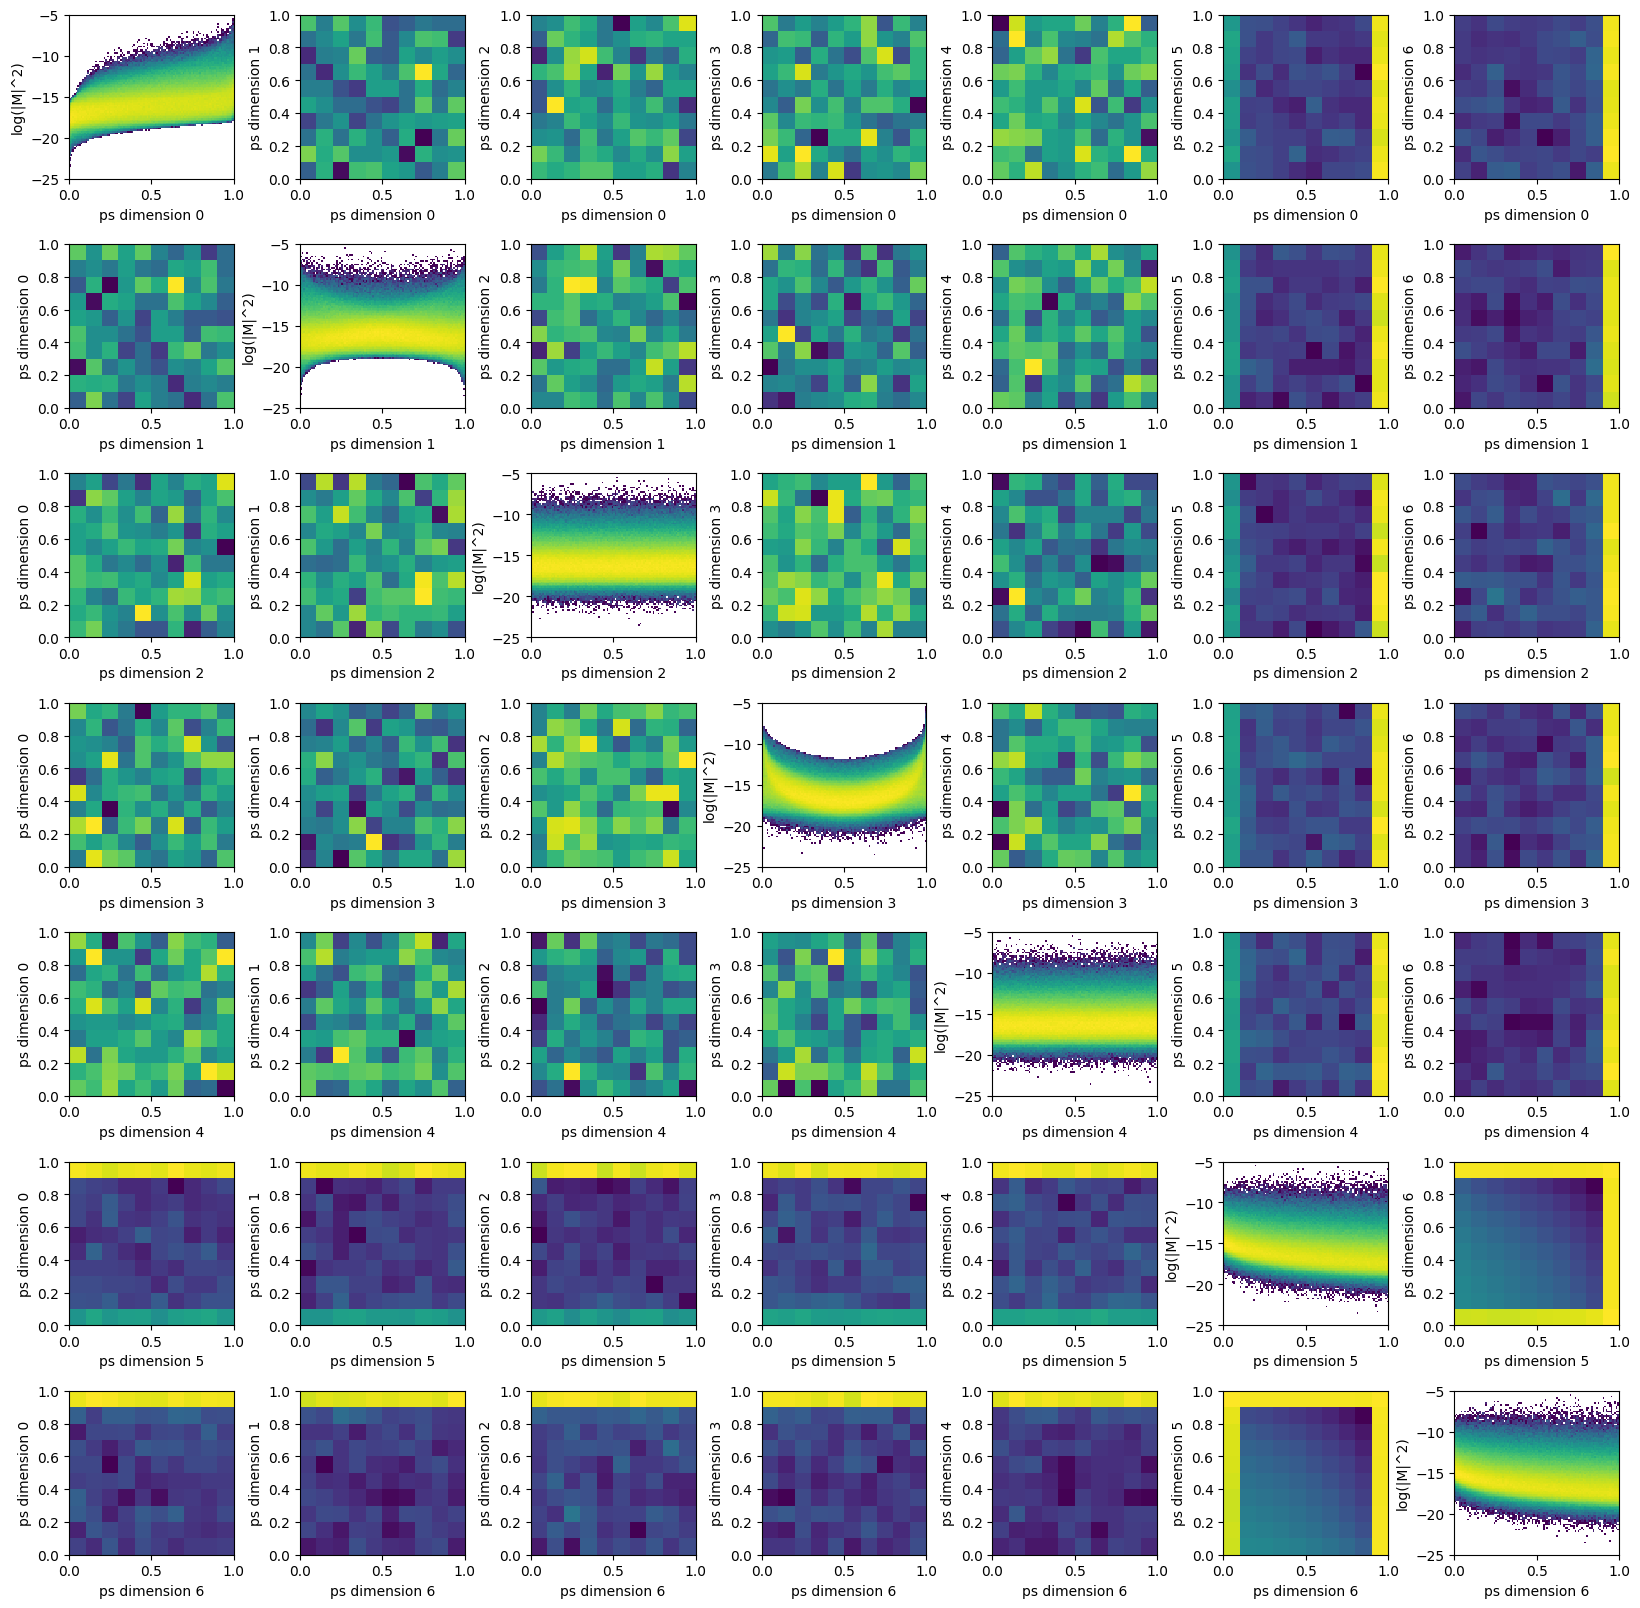

In [228]:
fig , axs = plt.subplots(7, 7, figsize=(20, 20), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(7):
    for j in range(7):
        ax = axs[i][j]
        # if j>i: 
        #     fig.delaxes(ax)
        #     continue
        
        if i == j:
            a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
                   logp_target,
                   bins=100, range=((0, 1), (-25,-5)), 
                   norm=LogNorm())
            ax.set_xlabel(f"ps dimension {i}")
            #plt.colorbar(I, ax=ax)
            ax.set_ylabel("log(|M|^2)")
        else:
            H, bx,by = np.histogram2d(
                ps_test[:,i].numpy(), 
                ps_test[:,j].numpy(),
                weights=np.exp(tot_target),
            bins=10, range=((0, 1), (0,1)))
            X, Y = np.meshgrid(bx, by)
            ax.pcolormesh(X, Y, np.log(H/1.5e6))
            ax.set_xlabel(f"ps dimension {i}")
            ax.set_ylabel(f"ps dimension {j}")
            #plt.colorbar(I, ax=ax, label="sum |M|^2")